In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import os
import glob
import torch
from tqdm import tqdm
from helpers import *
from sklearn.preprocessing import MinMaxScaler
from model import *
from IPython import display
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data_from_news.csv')
data

,Date,State,Occurence
0,2017-01-07,texas,1
1,2017-01-06,north carolina,1
2,2017-01-05,virginia,1
3,2017-01-06,texas,1
4,2017-01-07,new york,1
...,...,...,...
7818,2021-04-11,new york,1
7819,2021-04-11,texas,1
7820,2021-04-11,minnesota,1
7821,2021-04-11,new york,1


In [3]:
# Group data by weeks
# matrix, date = convert_data_to_matrix(data, group_data = True, group_days = 7)
matrix, date = convert_data_to_matrix(data)
matrix.shape

(1562, 50)

In [4]:
# scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize data by row
# Transpose input data as MinMaxScaler normalize by columns in default
# matrix = scaler.fit_transform(matrix.T).T

In [5]:
x, y = get_x_y(matrix, lookback = 4)
print(x.shape)
print(y.shape)
date = date[:x.shape[0]]
print(date.shape)

(1558, 4, 50)
(1558, 50)
(1558,)


In [6]:
train_loader, test_loader = split_data(x, y)

In [7]:
input_dim = matrix.shape[-1]
hidden_dim = 32
num_layers = 2
output_dim = matrix.shape[-1]
num_epochs = 200

In [8]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

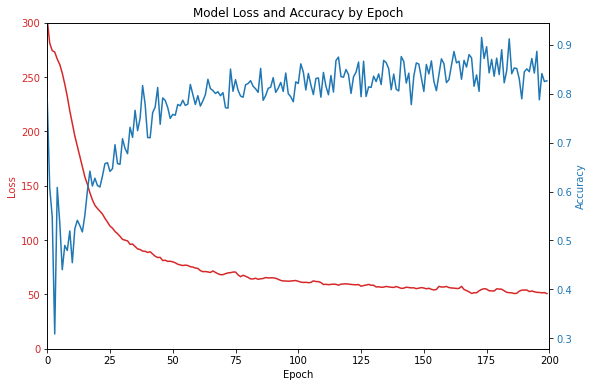

In [9]:
start = time.time()
LOSS, ACCU = [], []

for epoch in range(num_epochs):
    rloss = []
    acc = []
    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        rloss.append(loss.item())

    with torch.no_grad():
        for data in test_loader:
            x, y = data
            output = model(x)
            pred = get_pred(output)
            accu = calc_accuracy(pred, y)
            # accu = calc_strict_accuracy(pred, y)
            acc.append(accu)

    LOSS.append(np.mean(rloss))
    ACCU.append(np.mean(acc))

    fig, ax1 = plt.subplots()
    plt.axis([0, num_epochs, 0, 300])
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color = color)
    ax1.plot(LOSS, color = color)
    ax1.tick_params(axis='y', labelcolor = color)

    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color = color)
    ax2.plot(ACCU, color = color)
    ax2.tick_params(axis='y', labelcolor = color)
    plt.title('Model Loss and Accuracy by Epoch')
    fig.set_size_inches(9, 6)

    display.clear_output(wait=True)
    plt.pause(0.01)

    # print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.2f}%".format(epoch, num_epochs, LOSS[-1], ACCU[-1] * 100))
# total = time.time() - start
# print("Total train time: {} hrs {} mins".format(total // 3600, (total % 3600) // 60))


In [10]:
torch.save(model, 'prediction_model.pt')